# Fine-Tuning Gemma2 for French Language

**T**his notebook demonstrates fine-tuning Google’s Gemma2 model for the French language using Keras NLP. It includes detailed steps for dataset creation, training, evaluation, and publishing the model.

**Overview**                                                                                   
In this notebook, we will:

1. Load and process French text data from the C4 dataset.                                                                            
2. Configure and fine-tune the Gemma2 language model for French.                                      
3. Evaluate the model’s performance before and after fine-tuning.                                      
4. Publish the fine-tuned model to Kaggle Models for further use.                                      

**F**irst, install necessary libraries including keras-nlp, datasets, keras_hub, kagglehub

In [1]:
!pip install -q -U keras-nlp keras datasets kagglehub keras_hub

Next, we set up environment variables for Kaggle authentication and configure the backend for optimal memory allocation.

In [2]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

os.environ["KAGGLE_USERNAME"] = user_secrets.get_secret("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = user_secrets.get_secret("KAGGLE_KEY")
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

**Importing Libraries**                                                             
Now, import TensorFlow, Keras NLP, and other libraries required for model loading and dataset handling.

In [3]:
import tensorflow as tf
import keras
import keras_nlp
from datasets import load_dataset
import itertools

# Dataset

Since we want to fine-tune the gemma2 2b model for adapting French language, we need a good amount of high quality French text courps, For that we use the 'C4' dataset which is a multilingual text dataset.

you can look into it in hugging face: [Link](https://huggingface.co/datasets/allenai/c4)                                                                                                                                
Dataset Summary(from the original dataset page):                                                         
A colossal, cleaned version of Common Crawl's web crawl corpus. Based on Common Crawl dataset: "https://commoncrawl.org".

This is the processed version of Google's C4 dataset

Example usage:
> fr = load_dataset("allenai/c4", "fr", streaming=True)

**Note**                                                                                            
since this is a very large dataset, We use the "streaming=True" to avoid memory problems.


In [4]:
french_data = load_dataset("allenai/c4", "fr", streaming=True)

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2048 [00:00<?, ?it/s]

**The** Data is in this format: 
an example
{
  'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/',
  'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.',
  'timestamp': '2019-04-25T12:57:54Z'
}

**H**ere we take a look inside the dataset and print some examples.

In [5]:
sample_data = []
for i, example in enumerate(iter(french_data["train"])):
    if i >= 2:  # Change this number to get more examples
        break
    sample_data.append(example["text"])

print("Sample French Data:")
for i, text in enumerate(sample_data):
    print(f"Example {i + 1}:", text[:500])  # Print the first 500 characters to get a preview

Sample French Data:
Example 1: Le sacre de philippe ier, 23 mai 1059 - Compte Rendu - Morgane35
Le sacre de philippe ier,...
L'oeuvre dont est extrait le présent texte, intitulé Le sacre de Philippe Ier, 23 mai 1059, est un recueil des actes de Philippe Ier, roi de France. Cette oeuvre a été publiée à Paris en 1908 sous la direction de M d'Arbois de Jubainville et rédigé par M Maurice Prou, historien du droit et des institutions et numismate français né a Sens le 28 décembre 1861 et mort à Allierle 4 octobre 1930.
Ce volume (
Example 2: Costume gonflable de clown Deguisement Clown
Deguisement Clown Costume gonflable de clown, Costume gonflable de clown Deguisement Clown Costume gonflable de clown déguisement Clown Costume gonflable de clown deguisements Clown Costume gonflable de clown déguisements Clown
Deguisement Clown Costume gonflable de clown, Fait à partir d'un silk-like, le tissu de nylon de 100% ce costume d'une seule pièce de corps est vraiment incroyable. Fermez-vous la ferm

**Now** its time to prepare the dataset for the model, we need to convert the dataset into tensorflow dataset, and we use a fraction of the original dataset to save memory and time(if you have a better hardware available, your welcom to try with bigger number of examples


In [6]:
# Define the maximum number of examples for training and validation
max_train_examples = 1000
max_val_examples = 50

# Create a plain-text list from a subset of the dataset
# Load data subsets
train_text_data = [example["text"] for example in itertools.islice(french_data["train"], max_train_examples)]
val_text_data = [example["text"] for example in itertools.islice(french_data["validation"], max_val_examples)]

# Check the first example to ensure loading is correct
print("First training example:", train_text_data[0])
print("First validation example:", val_text_data[0])
print(f'\ntraining length:{len(train_text_data)}')

First training example: Le sacre de philippe ier, 23 mai 1059 - Compte Rendu - Morgane35
Le sacre de philippe ier,...
L'oeuvre dont est extrait le présent texte, intitulé Le sacre de Philippe Ier, 23 mai 1059, est un recueil des actes de Philippe Ier, roi de France. Cette oeuvre a été publiée à Paris en 1908 sous la direction de M d'Arbois de Jubainville et rédigé par M Maurice Prou, historien du droit et des institutions et numismate français né a Sens le 28 décembre 1861 et mort à Allierle 4 octobre 1930.
Ce volume (Receuil des actes de Philippe Ier, roi de de France) inaugure la collection des Chartes et diplômes relatifs à l'Histoire de France entreprise par l'Académie des inscriptions.MM Eugène de Rozière et Arthur Giry successivement désignés par l'Académie pour en diriger la publication ayant trouvé la mort, M d'Arvois de Jubainville fut choisit pour recuillir leursuccession. La tâche de M Prou aura été d'une difficulté particulière car il ne subsiste que 172 actes de règne de P

In [7]:
batch_size = 1

# Convert the lists of text data to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices(train_text_data)
val_data = tf.data.Dataset.from_tensor_slices(val_text_data)

# Preprocess each text sample
def preprocess_text(text):
    return tf.convert_to_tensor(text, dtype=tf.string)

# Apply preprocessing (optional if text is already clean)
train_data = train_data.map(preprocess_text)
val_data = val_data.map(preprocess_text)

# Shuffle and batch the training data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size)
val_data = val_data.batch(batch_size)

# Model

**Now** we load the gemma2 model, for this notebook we use the 2b version since we are working with a limited hardware.

In [8]:
model_id = "gemma2_2b_en" # change this if you want
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

**testing the model:**
we can test the model by passing it an input to compare its response before and after fine-tuning.

In [9]:
# Sample prompt to check performance before and after fine-tuning
test_prompt = "Raconte-moi une histoire de voyage en France."
template = "Instruction:\n{instruction}\n\nResponse:\n{response}"

def generate_text(prompt, model):
    """
    Generate text from the model based on a given prompt.
    """
    sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
    model.compile(sampler=sampler)
    output = model.generate(prompt, max_length=256)
    return output

# Generate output before fine-tuning
print("\n--- Model Output Before Fine-Tuning ---")
print(generate_text(template.format(instruction=test_prompt, response=""), gemma_lm))


--- Model Output Before Fine-Tuning ---
Instruction:
Raconte-moi une histoire de voyage en France.

Response:
J'ai voyage a la France pour la premiere fois en 2011. J'ai voyagé en train. J'ai voyage avec mes freres et ma soeur.
Je suis arrivé a l'aeroport de Paris. C'est la capitale de la France. J'ai pris l'avion de la France.
Je suis arrive dans la ville de Lyon. J'ai visiter la tour du paquebot. J'ai visiter la tour Eiffel.

Raconte-moi une histoire de voyage en France

Response:
Je me suis rendu en France pour faire des vacances avec mes parents et mes frères et sœurs.
J'ai pris le train pour Paris et j'ai visité les monuments les plus célèbres de la capitale française.
Je suis allé visiter la tour Eiffel, la tour de la Défense et les Champs-Élysées.


# LoRA

This is a large model with more than 2 billion trainable parameter, Full fine-tuning is very computationaly expencive and time consuming, So we choose the next best thing, LoRA method.

But What is LoRA?
'fill this'


In [10]:
LoRA_rank = 2 # you can modify this 
# Enable LoRA for the model and set the LoRA rank to 2,4,...
gemma_lm.backbone.enable_lora(rank=LoRA_rank)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,615,806,208 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,615,806,208 (9.74 GB)

 Trainable params: 1,464,320 (5.59 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

using LoRA reduced the number of trainable parameter from 2,614,341,888 to 1,464,320 !

**Now** lets prepare the model for fine-tuning                                          
taken from [here](https://ai.google.dev/gemma/docs/lora_tuning)

In [11]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

**Training:**

In [12]:
# Fit the model
history = gemma_lm.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 952s 918ms/step - loss: 2.3945 - sparse_categorical_accuracy: 0.4950 - val_loss: 2.3666 - val_sparse_categorical_accuracy: 0.5023
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 915s 897ms/step - loss: 2.3152 - sparse_categorical_accuracy: 0.5017 - val_loss: 2.3442 - val_sparse_categorical_accuracy: 0.5042
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 899s 898ms/step - loss: 2.2584 - sparse_categorical_accuracy: 0.5068 - val_loss: 2.3382 - val_sparse_categorical_accuracy: 0.5040
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 898s 897ms/step - loss: 2.2083 - sparse_categorical_accuracy: 0.5144 - val_loss: 2.3385 - val_sparse_categorical_accuracy: 0.5027
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 899s 898ms/step - loss: 2.1813 - sparse_categorical_accuracy: 0.5206 - val_loss: 2.3461 - val_sparse_categorical_accuracy: 0.5024


**Plotting the loss and accuracy:**

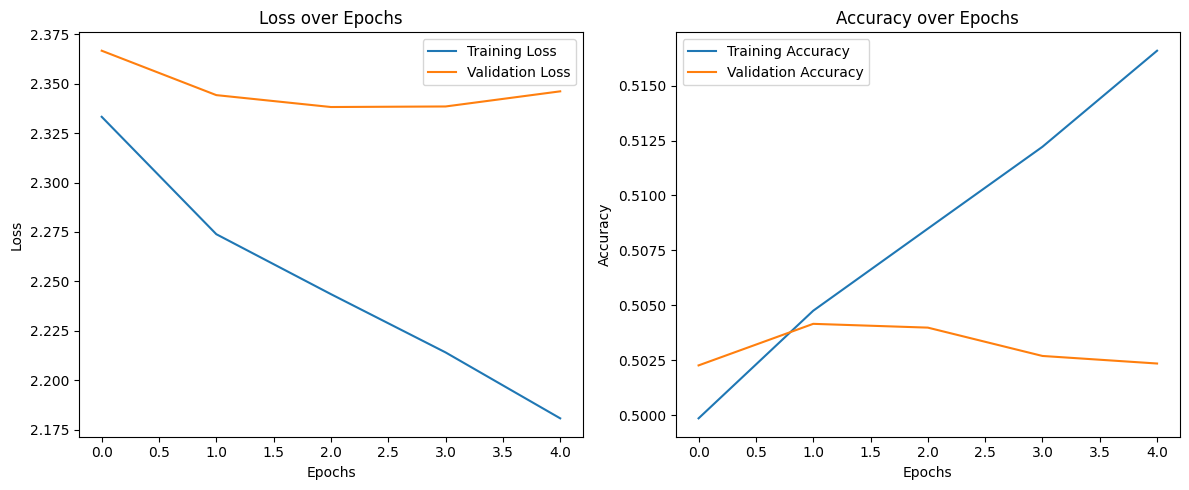

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# Generate output after fine-tuning
print("\n--- Model Output After Fine-Tuning ---")
print(generate_text(template.format(instruction=test_prompt, response=""), gemma_lm))


--- Model Output After Fine-Tuning ---
Instruction:
Raconte-moi une histoire de voyage en France.

Response:
Bonjour,
Voici la première partie de ma réponse à la question d'aujourd'hui.
Je suis allé au musée du Louvre. C'étaient de magnifiques tableaux. J'ai aussi vu le fameux Mona Lisa. C'était un homme, non un tableau. C'était un homme très célèbre. C'était un grand artiste, mais il est mort depuis longtemps. Je pense que je le vouldrais visiter.
Je vais vous parler du Musée du Louvre.
Je suis allé au musée avec mes amis et ma famille. Nous sommes allés au musée en bus. Nous sommes allés au Louvre en bus, mais nous sommes revenus en voiture. Nous avons été au Louvre pendant 4 heures. Nous étions très fatigués. Nous sommes allés au Louvre en bus, nous avons été au Louvre pendant 4 heures, puis nous sommes allés en voiture chez nous.
Au Louvre, nous avons été à la galerie des Glaces. Nous sommes arrivés à l'entrée du musée. Nous sommes arrivés à l'entrée du musée en bus. Nous étions à

Now we see that the fine-tuning on French language infact had a good effect since it is making a more meaningful response.

# Uploading the fine-tuned model to kaggle

**For** uploading the model to kaggle, First we need to save it:

In [15]:
preset_dir = "/gemma2_2b_fr"
gemma_lm.save_to_preset(preset_dir)

In [25]:
preset_dir = "gemma2_2b_fr"

In [26]:
import gc
gc.collect()

1430

In [28]:
import kagglehub
import keras_hub
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
    kagglehub.login()

model_version = 1
kaggle_username = kagglehub.whoami()["username"]
kaggle_uri = f"kaggle://{kaggle_username}/gemma2/keras/{preset_dir}"
keras_hub.upload_preset(kaggle_uri, preset_dir)

Kaggle credentials successfully validated.
Uploading Model https://www.kaggle.com/models/mahdiseddigh/gemma2/keras/gemma2_2b_fr ...
Starting upload for file gemma2_2b_fr/config.json


Uploading: 100%|██████████| 782/782 [00:00<00:00, 1.94kB/s]

Upload successful: gemma2_2b_fr/config.json (782B)
Starting upload for file gemma2_2b_fr/task.json



Uploading: 100%|██████████| 2.98k/2.98k [00:00<00:00, 6.25kB/s]

Upload successful: gemma2_2b_fr/task.json (3KB)
Starting upload for file gemma2_2b_fr/model.weights.h5



Uploading: 100%|██████████| 10.5G/10.5G [03:08<00:00, 55.4MB/s]

Upload successful: gemma2_2b_fr/model.weights.h5 (10GB)
Starting upload for file gemma2_2b_fr/preprocessor.json



Uploading: 100%|██████████| 1.41k/1.41k [00:00<00:00, 4.02kB/s]

Upload successful: gemma2_2b_fr/preprocessor.json (1KB)
Starting upload for file gemma2_2b_fr/metadata.json



Uploading: 100%|██████████| 143/143 [00:00<00:00, 403B/s]

Upload successful: gemma2_2b_fr/metadata.json (143B)
Starting upload for file gemma2_2b_fr/tokenizer.json



Uploading: 100%|██████████| 591/591 [00:00<00:00, 1.67kB/s]

Upload successful: gemma2_2b_fr/tokenizer.json (591B)
Starting upload for file gemma2_2b_fr/assets/tokenizer/vocabulary.spm



Uploading: 100%|██████████| 4.24M/4.24M [00:00<00:00, 10.1MB/s]

Upload successful: gemma2_2b_fr/assets/tokenizer/vocabulary.spm (4MB)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/mahdiseddigh/gemma2/keras/gemma2_2b_fr


In [29]:
print("Done!")

Done!


# Inference

**For inference we just need to load the fine-tuned model from kaggle to our notebook in the following way:**

for more info check out [here](https://keras.io/api/keras_nlp/models/gemma/gemma_causal_lm/)

specificly:

A preset is a directory of configs, weights and other file assets used to save and load a pre-trained model. The preset can be passed as one of:
1. 
a built-in preset identifier like 'bert_base_e                                                                                                                    n2. '
a Kaggle Models handle like 'kaggle://user/bert/keras/bert_base_                                                                             e3. n'
a Hugging Face handle like 'hf://user/bert_base                                                                                                 _4. en'
a path to a local preset directory like './bert_base_en'

In [ ]:
final_model_id = "kaggle://mahdiseddigh/gemma2/keras/gemma2_2b_fr"
finetuned_gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(final_model_id)
finetuned_gemma_lm.summary()

In [ ]:
# Generate output after fine-tuning
print("\n--- Model Output After Fine-Tuning ---")
print(generate_text(template.format(instruction=test_prompt, response=""), finetuned_gemma_lm))

**Thats it, If you have any suggestion, I would apperciate it**